In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import h5py
from matplotlib import colors
import matplotlib.pyplot as plt
import multiprocessing
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import ssm
from ssm.util import find_permutation
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from multi_process import slds_eigs_worker
from nld_utils import simulate_lorenz
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save

# Load Neural Data

In [5]:
# filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolWakeup/Mary-Anesthesia-20170203-02.mat'
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
# electrode_info, lfp_schema, session_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'unitInfo'], verbose=False)
dt = lfp_schema['smpInterval'][0]

f = h5py.File(filename, 'r')
airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 100.67 seconds)


# Load Results

In [7]:
%%time 
data_dir = "/home/adameisen/Documents/MIT/code/ChaoticConsciousness/__data__/slds/slds_big_run_latent_2_duration_5_stride_5_Oct-28-2021_1833"
run_params = load(os.path.join(data_dir, "run_params"))
results_files = [f for f in os.listdir(data_dir) if f.startswith('start_time')]
results = []
for file in results_files:
    results.append(load(os.path.join(data_dir, file)))
results = sorted(results, key=lambda d: d['start_time'])
results = pd.DataFrame(results)

CPU times: user 827 ms, sys: 4.21 s, total: 5.03 s
Wall time: 28.4 s


# Test

In [34]:
run_params['unit_indices'] = np.arange(len(electrode_info['area']))[pd.Series(electrode_info['area']).isin(['vlPFC'])]

In [99]:
unit_indices = run_params['unit_indices']
length = run_params['length'] # the length of a window
n_samp = 10 # number of times to sample from the SLDS, aveage over these times
T_samp = 20 # the number of time bins to sample forward

interval = 5 # number of windows to use
indices = np.arange(len(results) - 1)
indices = [i for i in indices if i % interval == 0]

start_times = np.zeros(len(indices))

predictions = np.zeros((len(indices), 1, T_samp, len(unit_indices)))
prediction_mse = np.zeros((len(indices), 1, T_samp)) # for each index predict forward only from the end of the window
for num, index in enumerate(tqdm(indices)):
    row = results.iloc[index]
    start_times[num] = row.start_time
    
    slds = row.slds
    q_test = row.q_lem
    start_step = row.start_step
    ts = [results.iloc[index + 1].start_step]
#     ts = [results.iloc[index].start_step]
#     ts = [results.iloc[index + 800].start_step]
#     print(results.iloc[index + 800].start_time)

    for i, t in enumerate(ts):
#         elbo_test,q_test = slds.approximate_posterior(lfp[t-length + 1:t + 1, unit_indices], num_iters=10, verbose=False) 
#         elbo_test,q_test = slds.approximate_posterior(lfp[t:t + length, unit_indices], num_iters=10, verbose=False) 
        x_test=q_test.mean_continuous_states[0][-1:]
#         x_test=q_test.mean_continuous_states[0][0:1]
        z_test=np.argmax(q_test.mean_discrete_states[0][-1:],axis=1)
#         z_test=np.argmax(q_test.mean_discrete_states[0][0:1],axis=1)

        for n in range(n_samp):
            [z_pred,x_pred,y_pred]=slds.sample(T_samp, prefix=(z_test,x_test,lfp[t:t+1, unit_indices]))
#             y_pred_current = slds.smooth(x_test, lfp[t:t+1, unit_indices])
            predictions[num][i] += y_pred
#             prediction_mse[num][i] += ((y_pred - lfp[t + 1:t + T_samp + 1, unit_indices])**2).mean(axis=1)

        predictions[num] /= n_samp
        prediction_mse[num] /= n_samp
        
        break
    break

  0%|          | 0/284 [00:00<?, ?it/s]

In [103]:
slds.dynamics._As

array([[[ 0.98988841, -0.00123918],
        [ 0.03245333,  0.98250861]],

       [[ 0.98828029, -0.00145899],
        [ 0.02987616,  0.98225613]]])

In [100]:
print(lfp[t:t+1, unit_indices]), lfp[t + 1:t + T_samp + 1, unit_indices]

[[-1.42800533e-02  1.52345036e-02  5.22348473e-02  4.22104370e-02
   2.24017955e-02  5.03079333e-02  3.54871240e-02  5.20339858e-02
   1.02387342e-02  2.83625238e-02  2.24002203e-02  4.51729734e-02
   4.29484099e-02  4.21606187e-02  3.73898882e-02  4.26687293e-02
   2.71770544e-02  3.01803805e-02  3.33671958e-02  3.76047907e-02
   4.87466415e-02  5.48075691e-02  3.02554658e-02  3.46251285e-02
   2.72583837e-02 -9.87738802e-05  2.04288024e-02  3.88769037e-02
   3.85338314e-02  5.52857865e-02  4.33738995e-02  3.06357842e-02
   1.16390570e-02 -2.29296437e-02  1.67793736e-02  3.10265316e-02
   3.71922295e-02  4.37339959e-02  4.17510911e-02  2.68617642e-02
   4.01538433e-02  3.82534051e-02  4.58834679e-02  4.07329835e-02
   4.07103211e-02  4.20379827e-02  2.79184589e-02  2.03167738e-02
   3.90182539e-02  3.71843465e-02  3.74188481e-02  3.85012072e-02
   3.17591985e-02  2.49033663e-02  2.66866508e-02  1.55353565e-02
   3.47707110e-02  2.90907088e-02  3.32715463e-02  2.89199963e-02
   3.55074

(None,
 array([[-0.01569558,  0.01796771,  0.04642547, ...,  0.03426103,
          0.02860913,  0.01634843],
        [-0.02312006,  0.02368164,  0.03661185, ...,  0.03057936,
          0.02382535,  0.01279519],
        [-0.02083917,  0.01574699,  0.02294206, ...,  0.02581621,
          0.0197257 ,  0.00769491],
        ...,
        [-0.02843956, -0.00548658,  0.0047927 , ...,  0.00478294,
         -0.00317098, -0.00745506],
        [-0.02771897, -0.00102388,  0.00903387, ..., -0.00124879,
         -0.00244431, -0.00975766],
        [-0.02701102,  0.00422347,  0.01324899, ..., -0.00538151,
         -0.00267086, -0.00889116]]))

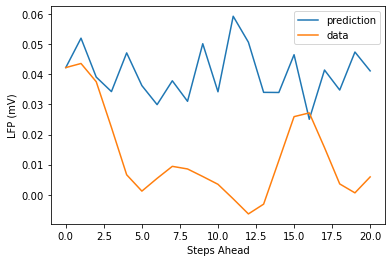

In [111]:
window_num = 0
unit_ind = 3
plt.plot(np.concatenate([lfp[t:t+1, unit_indices[unit_ind]], predictions[window_num][0][:, unit_ind]]), label='prediction')
plt.plot(lfp[t:t + T_samp + 1, unit_indices[unit_ind]], label='data')
# plt.xlim([0, 20])
plt.xlabel('Steps Ahead')
plt.ylabel('LFP (mV)')
plt.legend()
plt.show()

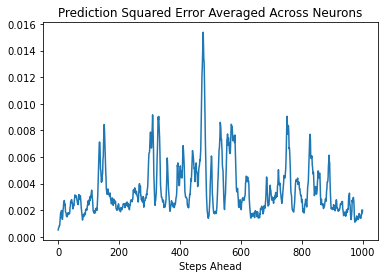

In [138]:
plt.plot(prediction_mse[0][0])
plt.xlabel('Steps Ahead')
plt.title('Prediction Squared Error Averaged Across Neurons')
plt.show()

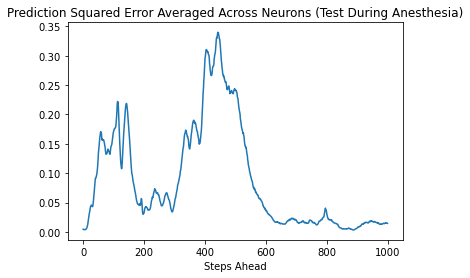

In [134]:
plt.plot(prediction_mse[0][0])
plt.xlabel('Steps Ahead')
plt.title('Prediction Squared Error Averaged Across Neurons (Test During Anesthesia)')
plt.show()